In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np

In [125]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])
dataset = torchvision.datasets.MNIST('../../data/mnist', train=True, transform=transform, download=False)

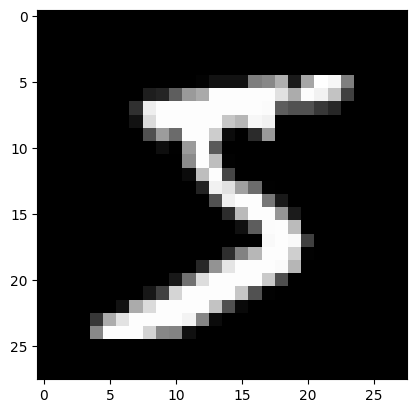

In [126]:
plt.imshow(dataset[0][0].permute(1, 2, 0), cmap='gray');

In [4]:
def show_images(images, title=None):
    plt.axis('off')
    plt.imshow(torchvision.utils.make_grid((images + 1) / 2).permute(1, 2, 0))
    if title is not None:
        plt.title(title)
    plt.show()

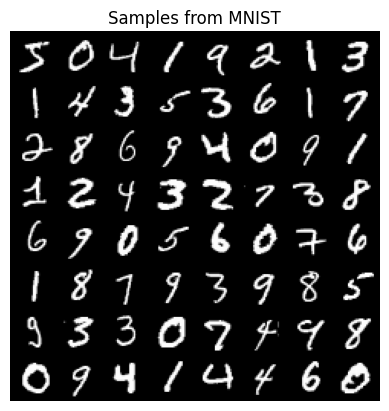

In [5]:
show_images(torch.stack([dataset[i][0] for i in range(64)]), title='Samples from MNIST');

In [155]:
class Generator(nn.Module):
    def __init__(self, z_dim, hidden_dim, img_channels):
        super().__init__()

        self.net = nn.Sequential( # 1x1
            self.__basic_block(in_channels=z_dim, out_channels=hidden_dim*8, kernel_size=3, stride=1, padding=0),
            self.__basic_block(in_channels=hidden_dim*8, out_channels=hidden_dim*4, kernel_size=3, stride=2, padding=1),
            self.__basic_block(in_channels=hidden_dim*4, out_channels=hidden_dim*2, kernel_size=4, stride=2, padding=0),
            self.__basic_block(in_channels=hidden_dim*2, out_channels=hidden_dim, kernel_size=4, stride=1, padding=1),
            nn.ConvTranspose2d(hidden_dim, img_channels, kernel_size=4, stride=2, padding=0), 
            nn.Tanh(),
        )
    
    def __basic_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.net(x)
    
    
noise = torch.randn(1, 100, 1, 1)
Generator(100, 64, 1)(noise).shape

torch.Size([1, 1, 28, 28])

In [156]:
class Critic(nn.Module):
    def __init__(self, img_channels, hidden_dim):
        super().__init__()
        
        self.net = nn.Sequential( # 28x28
            self.__basic_block(img_channels, hidden_dim, kernel_size=3, stride=1), 
            self.__basic_block(hidden_dim, hidden_dim*2, kernel_size=3, stride=1), 
            self.__basic_block(hidden_dim*2, hidden_dim*4, kernel_size=3, stride=2), 
            self.__basic_block(hidden_dim*4, hidden_dim*8, kernel_size=4, stride=2), 
            nn.Conv2d(hidden_dim*8, 1, kernel_size=4), 
        )

    def __basic_block(self, in_channels, out_channels, kernel_size, stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(negative_slope=0.2)
        )

    def forward(self, x):
        return self.net(x).view(x.size(0), 1)


x = torch.randn(32, 1, 28, 28)
Critic(1, 16)(x).shape

torch.Size([32, 1])

In [2]:
NOISE_DIM = 100
BATCH_SIZE = 64
NUM_EPOCHS = 30
NUM_CRITIC_UPDATE = 5
GP_LAMBDA = 10
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

In [158]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [159]:
def calc_gradient_penalty(critic, real_images, fake_images):
    eps = torch.rand((real_images.size(0), *(1 for _ in range(len(real_images.shape) - 1))), requires_grad=True).to(device)
    intermediate_images = eps * real_images + (1 - eps) * fake_images
    scores = critic(intermediate_images)
    gradients = torch.autograd.grad(outputs=scores, inputs=intermediate_images, grad_outputs=torch.ones_like(scores), create_graph=True, retain_graph=True)[0]
    gradients_norm = torch.norm(gradients.view(gradients.shape[0], -1), dim=1)
    gp = torch.mean((gradients_norm - 1) ** 2)
    return gp

In [162]:
gen = Generator(z_dim=NOISE_DIM, hidden_dim=64, img_channels=1).to(device).apply(init_weights)
crit = Critic(img_channels=1, hidden_dim=16).to(device).apply(init_weights)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

opt_gen = torch.optim.Adam(gen.parameters(), lr=0.001, betas=(0.5, 0.9))
opt_crit = torch.optim.Adam(crit.parameters(), lr=0.001, betas=(0.5, 0.9))

scheduler_gen = torch.optim.lr_scheduler.MultiStepLR(opt_gen, milestones=[10])
scheduler_crit = torch.optim.lr_scheduler.MultiStepLR(opt_crit, milestones=[10])

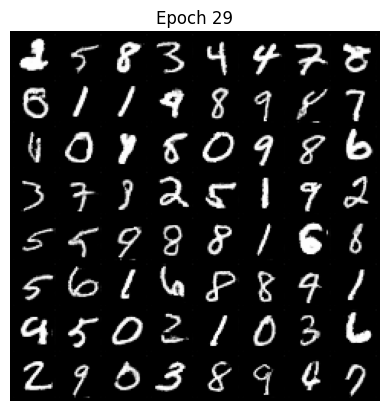

In [164]:
fixed_noise = torch.randn(64, NOISE_DIM, 1, 1).to(device)
images = []
transf = transforms.Compose([transforms.ToPILImage(), transforms.Lambda(lambda x: np.array(x)[:, :, 0])])

for epoch in range(NUM_EPOCHS):
    for real_images, _ in dataloader:
        real_images = real_images.to(device)

        #----- Updating the Discriminator -----#
        for _ in range(NUM_CRITIC_UPDATE):
            noise = torch.randn(real_images.shape[0], NOISE_DIM, 1, 1).to(device)
            fake_images = gen(noise).detach()
            loss = -torch.mean(crit(real_images)) + torch.mean(crit(fake_images)) + GP_LAMBDA*calc_gradient_penalty(crit, real_images, fake_images)
            crit.zero_grad()
            loss.backward(retain_graph=True)
            opt_crit.step()

        #----- Updating the Generator -----#
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        loss = -torch.mean(crit(gen(noise)))
        gen.zero_grad()
        loss.backward()
        opt_gen.step()
    
    scheduler_gen.step()
    scheduler_crit.step()

    clear_output()
    show_images(gen(fixed_noise).detach().cpu(), title=f"Epoch {epoch}")
    images.append(transf(torchvision.utils.make_grid((gen(fixed_noise) + 1) / 2).detach().cpu()))


In [165]:
torch.save(gen.state_dict(), 'gen.pth')
torch.save(crit.state_dict(), 'crit.pth')

In [167]:
gen.load_state_dict(torch.load('gen.pth'))
crit.load_state_dict(torch.load('crit.pth'));

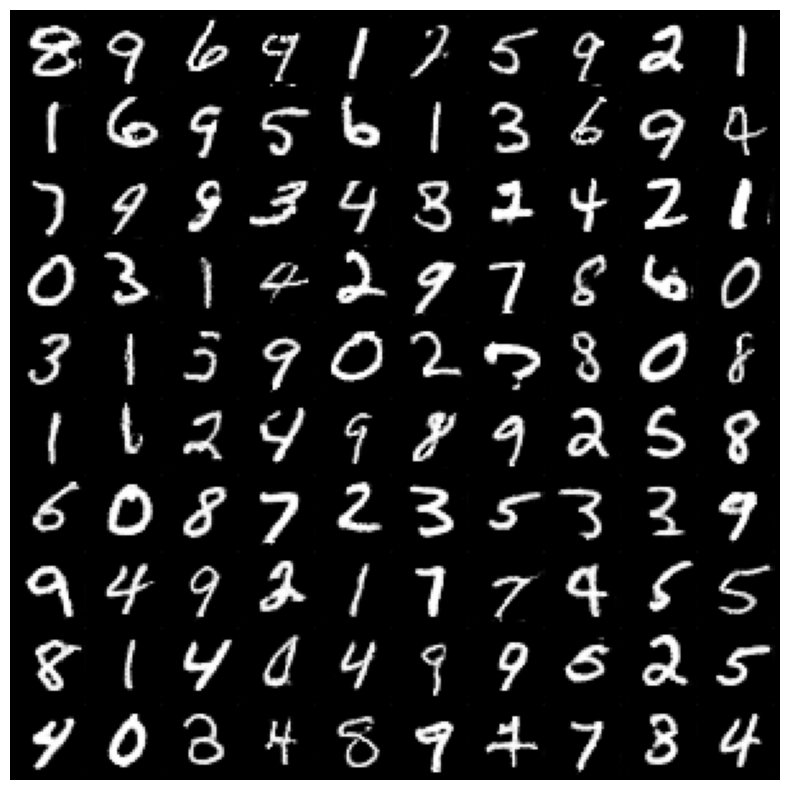

In [170]:
z = torch.randn(100, NOISE_DIM, 1, 1).to(device)
gen_imgs = gen(z)

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(torchvision.utils.make_grid(gen_imgs, normalize=True, nrow=10).cpu().permute(1, 2, 0));

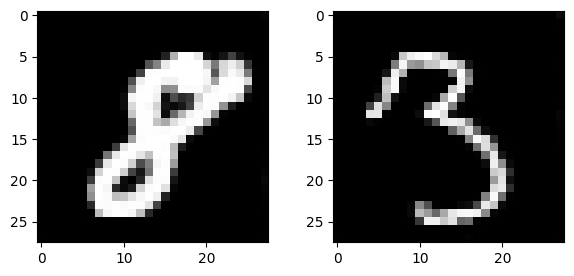

In [178]:
noise = torch.randn(2, NOISE_DIM, 1, 1).to(device)
images = gen(noise).detach().cpu().permute(0, 2, 3, 1)

fig, axs = plt.subplots(1, 2, figsize=(7, 3))
axs[0].imshow(images[0], cmap="gray")
axs[1].imshow(images[1], cmap="gray");

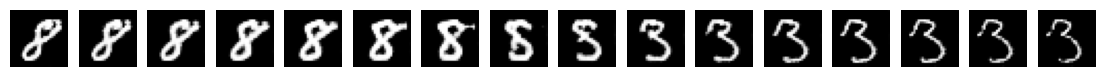

In [179]:
cnt = 15
step = (noise[1] - noise[0]) / cnt
interpolated_noises = []
for i in range(cnt+1):
    interpolated_noises.append(noise[0] + step * i)


interpolated_images = gen(torch.stack(interpolated_noises)).detach().cpu().permute(0, 2, 3, 1)

fig, axs = plt.subplots(1, cnt+1, figsize=(14, 2))
for i in range(cnt+1):
    axs[i].axis("off")
    axs[i].imshow(interpolated_images[i], cmap="gray")